In [ ]:
# %pip install tensorflow
# %pip install gym
# %pip install keras
# %pip install keras-rl2
# %pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from mss import mss
import numpy as np 
import time
import pydirectinput
import pygetwindow
import cv2
import win32gui
import pytesseract
from image_analysis.take_screenshot import Screenshot
from input_sending.input_sending import SendInput 
from text_recognition.text_recog import RecognizeText 
from pattern_recognition.pattern_recog import RecognizePattern 

In [ ]:
class StepManiaEnv(Env):
    
    # Setup
    def __init__(self):
        super().__init__()
        self.action_space = Discrete(5)

        # Observation Array
        self.observation_space = Box(
            low=0, 
            high=255, 
            shape=(1, 170, 100), 
            dtype=np.uint
        )
        
        # Define extraction parameters for the game
        self.screenshot_helper = Screenshot()
        self.text_recog_helper = RecognizeText()
        self.input_sending_helper = SendInput()
        self.capture = mss()
        self.game_location = {'top': 35, 'left': 110, 'width': 290, 'height': 495}
        self.combo_location = {'top': 450, 'left': 570, 'width': 285, 'height': 30}
        self.done_location = {'top': 40, 'left': 25, 'width': 150, 'height':30}
        self.cur_held_buttons = {'a': False, 'd': False, 'w': False, 's': False}
        pytesseract.pytesseract.tesseract_cmd = r'G:\Programme\Tesseract\tesseract.exe'

    # What is called to do something in the game
    def step(self, action):

        # Apply action
        action_map = {
            0:'no_op',
            1:'a',
            2:'d',
            3:'w',
            4:'s',
        }

        if action != 0:
            if (list(self.cur_held_buttons.values())[action - 1]):
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = False
                self.input_sending_helper.releaseKey(action_map[action])
            else:
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = True
                self.input_sending_helper.holdKey(action_map[action])
        
        # Checking if the game is over
        done = self.get_over()
        # Get the next observation
        new_observation = self.get_observation()
        # Use score as reward
        reward = self.get_reward()
        info = {}

        return new_observation, reward, done, info

    # Restart the game
    def reset(self):
        
        # Exit to menu, select new song and start
        time.sleep(5)
        pydirectinput.press('enter')
        time.sleep(2)
        pydirectinput.press('d')
        pydirectinput.press('enter')

        return self.get_observation()

    # Get the part of observation of the game that we want
    def get_observation(self):

        # Screenshot gameplay and downscale
        raw = np.array(self.capture.grab(self.game_location))[:,:,:-1].astype(np.uint8)
        channel = self.screenshot_helper.downscaleImage(raw, (100, 170), (1, 170, 100))

        return channel

    # Get the current score as a reward
    def get_reward(self):

        # Screenshot score, downscale image and return number
        reward_img = np.array(self.capture.grab(self.combo_location))[:,:,:-1].astype(np.uint8)
        channel = self.screenshot_helper.downscaleImage(reward_img, (285, 30), (1, 30, 285))
        reward = env.text_recog_helper.get_number_from_image(channel[0])

        return reward

    # Get if the game is over
    def get_over(self):

        # Screenshot top left of screen, check for text and return of strings match
        done_capture = np.array(self.capture.grab(self.done_location))[:,:,::-1].astype(np.uint8)
        gray = cv2.cvtColor(done_capture, cv2.COLOR_BGR2GRAY)
        # Valid done text
        done_strings = ['Your Results']

        return self.text_recog_helper.is_text_in_image(gray, done_strings, 12)


In [ ]:
env = StepManiaEnv()

'E d E\n'

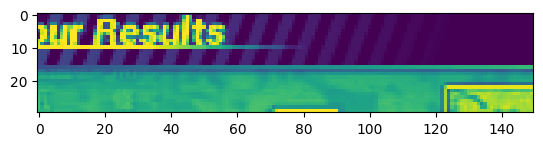

In [33]:
plt.imshow(env.get_over())
pytesseract.image_to_string(env.get_over(), lang='deu', config='--psm 7')

In [ ]:
print('Environment started - Random Inputs')
for episode in range(10):
  obs = env.reset()
  done = False
  final_reward = 0
  amount_of_screenshots = 0
  start = time.perf_counter()
  while not done:
    obs, reward, done, info = env.step(env.action_space.sample())
    amount_of_screenshots += 1
    if final_reward < reward:
      final_reward = reward

  stop = time.perf_counter()
  final_time = stop - start
  print(f'Total Reward for episode {episode} is {final_reward}')
  print(f'Total screenshots for episode {episode} is {amount_of_screenshots}')
  print(f'Total duration of episode {episode} is {final_time:0.4f} seconds')
  print(f'This equals an average of {amount_of_screenshots / final_time} images per second')

In [ ]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [ ]:
# Check if the environment is valid
env_checker.check_env(env)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
  def __init__(self, checking_freq, save_path, verbose=1):
    super(TrainAndLoggingCallback, self).__init__(verbose)
    self.checking_freq = checking_freq
    self.save_path = save_path

  def _init_callback(self):
    if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)

  def _on_step(self):
    if self.n_calls % self.checking_freq == 0:
      model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
      self.model.save(model_path)
    
    return True

In [ ]:
CHECKPOINT_DIR = './training/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(checking_freq=1_000, save_path=CHECKPOINT_DIR)

In [ ]:
from stable_baselines3 import DQN

In [ ]:
env = StepManiaEnv()

In [ ]:
model = DQN(
  'CnnPolicy',              
  env,                      # Used environment
  tensorboard_log=LOG_DIR,  # Log directory
  verbose=1,                # Enables logging
  buffer_size=120_000,      # Buffer size depending on amount of ram
  learning_starts=1_000,    # Learning starts after 1000 steps
  #device='cpu'             # Training on cpu or gpu
)

In [ ]:
# Start training
model.learn(total_timesteps=1_000, callback=callback)

In [ ]:
# Load past model 
# model.load(path)

In [ ]:
print('Environment started - Using Model')
for episode in range(1):
  obs = env.reset()
  done = False
  final_reward = 0
  amount_of_screenshots = 0
  start = time.perf_counter()
  while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(int(action))
    if final_reward < reward:
      final_reward = reward
      
  stop = time.perf_counter()
  final_time = stop - start
  print(f'Total Reward for episode {episode} is {final_reward}')
  print(f'Total screenshots for episode {episode} is {amount_of_screenshots}')
  print(f'Total duration of episode {episode} is {final_time:0.4f} seconds')
  print(f'This equals an average of {amount_of_screenshots / final_time} images per second')